# Retrieval

Retrieval is the centerpiece of our retrieval augmented generation (RAG) flow. 

Let's get our vectorDB from before.

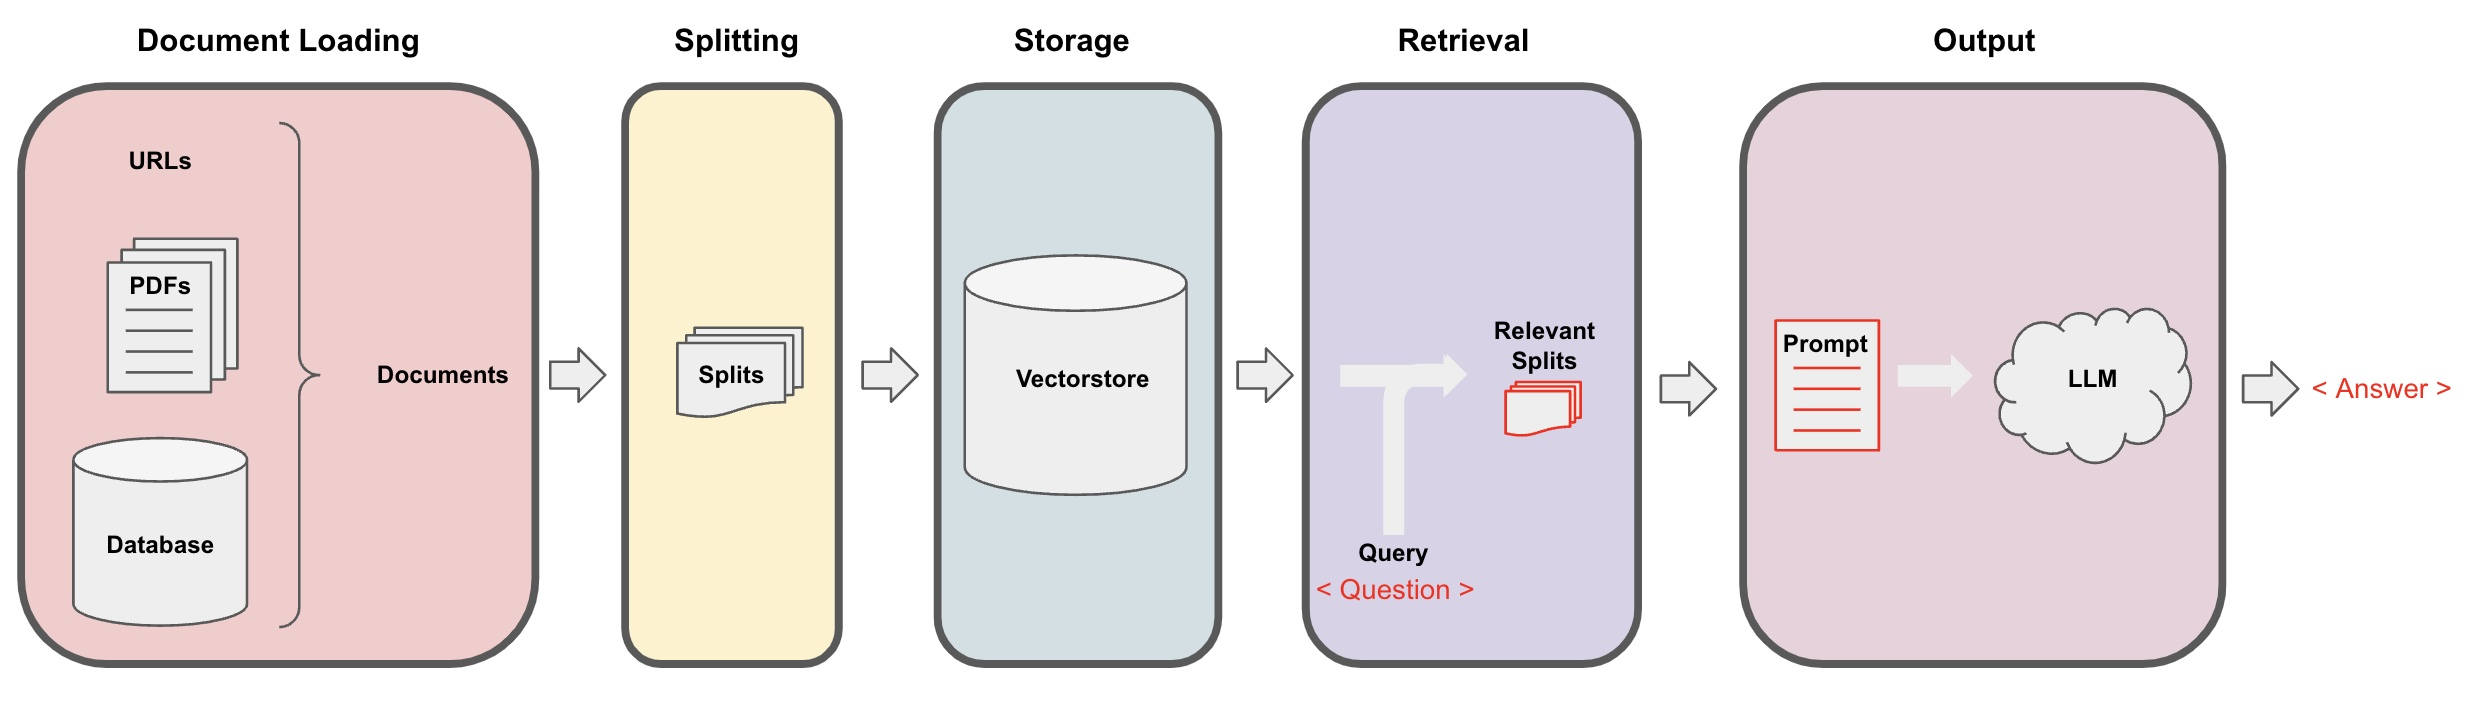

## Vectorstore retrieval


In [1]:
import os
import openai
import sys
import yaml

# change to your token
with open('./token.yaml', 'r') as file:
    keys = yaml.safe_load(file)
    
openai.api_key = keys["openai_key"]

In [2]:
#!pip install lark

### Similarity Search

In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'

In [4]:
embedding = OpenAIEmbeddings(openai_api_key=keys["openai_key"])
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

/Users/tylin/opt/anaconda3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [5]:
print(vectordb._collection.count())

209


In [6]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    #「鵝膏菌（Amanita phalloides）具有大型且顯眼的地上（地面上）子實體（子實體）。」
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    #「具有大型子實體的蘑菇是鵝膏菌（Amanita phalloides）。有些品種是全白的。」
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
    #「鵝膏菌（A. phalloides），又名死亡帽，是已知最毒的蘑菇之一。」
]

In [7]:
smalldb = Chroma.from_texts(texts, embedding=embedding) # 將上述的句子轉成向量存進Chroma中

In [8]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [9]:
smalldb.similarity_search(question, k=2) # 這兩個訊息都在講這個菇菇的外型，但其實我也想知道這個菇菇有沒有毒

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

In [10]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3) # k: 最終要返回幾個結果, fetch_k: 有幾個候選的結果

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

### Addressing Diversity: Maximum marginal relevance

Last class we introduced one problem: how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

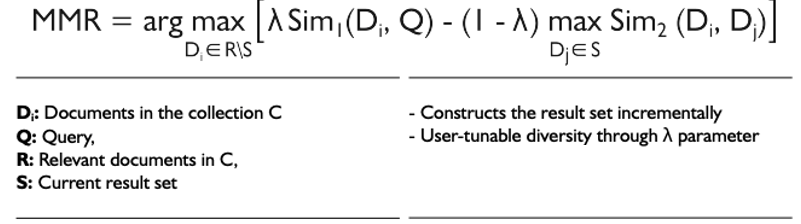



lambda越大，diversity越小；lambda越小，diversity越大。

In [11]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [12]:
docs_ss[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [13]:
docs_ss[1].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

Note the difference in results with `MMR`.

In [14]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3) # fetch_k: 20 (default) 
# lambda_mult (float): Defaults to 0.5.

In [15]:
docs_mmr[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [16]:
docs_mmr[1].page_content[:100]

'algorithm then? So what’s different? How come  I was making all that noise earlier about \nleast squa'

### Addressing Specificity: working with metadata

In last lecture, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

In [17]:
question = "what did they say about regression in the third lecture?"

In [18]:
# 可以自行對metadata設filter
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"docs/cs229_lectures/MachineLearning-Lecture03.pdf"}
)

In [19]:
for d in docs:
    print(d.metadata)

{'page': 0, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 14, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 4, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}


### Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:
 
1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

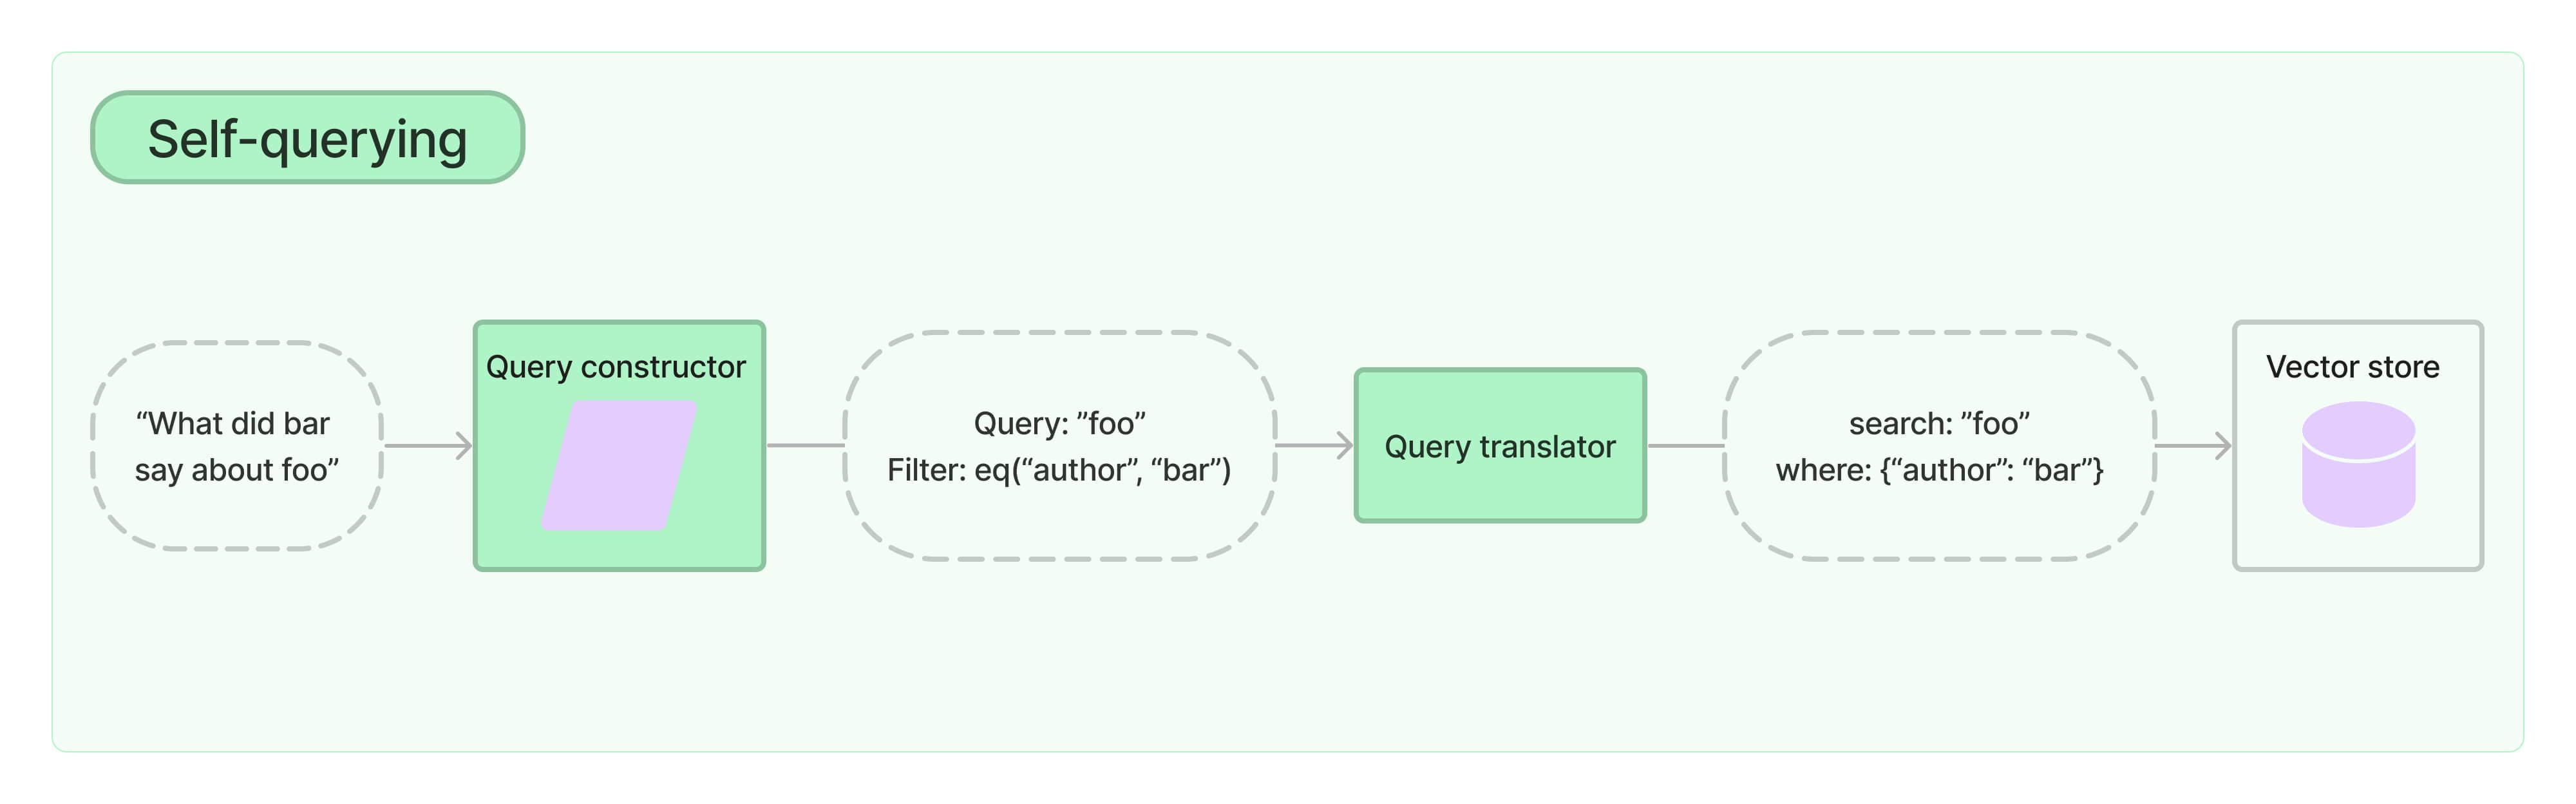

In [20]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [21]:
# 告訴retriever，要萃取出什麼資訊
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="""The lecture the chunk is from, should be one of 
                            `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, 
                            `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or 
                            `docs/cs229_lectures/MachineLearning-Lecture03.pdf`""",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

**Note:** The default model for `OpenAI` ("from langchain.llms import OpenAI") is `text-davinci-003`. Due to the deprication of OpenAI's model `text-davinci-003` on 4 January 2024, you'll be using OpenAI's recommended replacement model `gpt-3.5-turbo-instruct` instead.

In [22]:
document_content_description = "Lecture notes" # 告訴retriever, ducument的內文代表什麼意思
llm = OpenAI(model='gpt-3.5-turbo-instruct', temperature=0, openai_api_key=keys["openai_key"])
retriever = SelfQueryRetriever.from_llm(
    llm, 
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

/Users/tylin/opt/anaconda3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [23]:
question = "what did they say about regression in the third lecture?"

**You will receive a warning** about predict_and_parse being deprecated the first time you executing the next line. This can be safely ignored.

In [24]:
docs = retriever.get_relevant_documents(question)

/Users/tylin/opt/anaconda3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [25]:
for d in docs:
    print(d.metadata)

{'page': 14, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 10, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 0, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 10, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}


In [26]:
question = "what did they say on the page 3?"

In [27]:
docs = retriever.get_relevant_documents(question)

In [28]:
for d in docs:
    print(d.metadata)

{'page': 3, 'source': 'docs/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 3, 'source': 'docs/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 3, 'source': 'docs/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 3, 'source': 'docs/cs229_lectures/MachineLearning-Lecture01.pdf'}


### Additional tricks: compression

Another approach for improving the quality of retrieved docs is compression. (將retrieve出來的docs做精簡壓縮)

Information most relevant to a query may be buried in a document with a lot of irrelevant text. 

Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. 

In [29]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [30]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [31]:
# Wrap our vectorstore
llm = OpenAI(temperature=0, model="gpt-3.5-turbo-instruct", openai_api_key=keys["openai_key"])
compressor = LLMChainExtractor.from_llm(llm)

In [32]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [33]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)
# 可以看到搜尋出來的資訊變短了
# 但是搜出來的資訊有重複

Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write 

## Combining various techniques

In [34]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr") #讓diversity變高
)

In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)
# 可以結合不同的方法

## Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [ ]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# Load PDF
loader = PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


In [ ]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

In [ ]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]